<a href="https://colab.research.google.com/github/AviFeygin/EECS-4080/blob/main/Israpol_Simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install scikit-lego

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install statsmodels

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install lowess

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy
import torch
import scipy
import scipy.interpolate
import pandas as pd
import matplotlib.pyplot as plt
import keras as ker
import seaborn as sea
import xlrd as xlr
import numpy as np
from numpy.random import normal

import matplotlib.pyplot as plt
# import pymc3 as pm
# import theano
import statsmodels.api as stm

from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

#ignore all warnings
import warnings
warnings.filterwarnings('ignore')
sea.set()

import itertools
!pip install --upgrade xlrd

from google.colab import data_table
data_table.enable_dataframe_formatter()
data_table.max_columns = 30
from vega_datasets import data

verbose = 0

import statsmodels.api as sm # to build a LOWESS model
from scipy.interpolate import interp1d # for interpolation of new data points

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data = '/content/drive/MyDrive/Polls/Polls.xlsx'
polls = pd.read_excel(data)
polls_2021 = pd.read_excel(data, sheet_name=0, index_col=0)
election_results = polls[polls['Polling_Firm'] == 'Election results[5]']
polls.index = polls['Date'].copy()


In [ ]:
print("polls_2021 shape:")
print(polls_2021.shape)
just_polls = polls_2021.iloc[0:161, 4:25]

#fixing the float errors
just_polls['Days_Before_Election'] = just_polls['Days_Before_Election'].round().astype('int')

number_of_parties = 14
number_of_blocs = 4

polls_2021 shape:
(159, 23)


##defining the standard deviation function for calculating

In [ ]:
import math

#different Z scores for different confidence intervals
z_95 = 1.96
z_98 = 2.326
z_99 = 2.576

#function definition for calculating standard deviation from Z score and poll size
def standard_deviation_inverse_calc(pop, z = 1.96):
  sigma = (z/math.sqrt(pop))**-1
  return sigma


##calculating the Standard deviations

In [ ]:
Likud = polls[['Poll_Size','Likud']]
display(Likud)
display(len(Likud))

,Poll_Size,Likud
Date,,
2021-03-23 00:00:01,NaN,30.0
2021-03-20 00:00:02,900.0,31.0
2021-03-19 00:00:03,1103.0,30.0
2021-03-19 00:00:04,1000.0,32.0
2021-03-19 00:00:05,1406.0,31.0
...,...,...
2020-06-17 00:02:35,NaN,41.0
2020-06-17 00:02:36,NaN,41.0
2020-06-11 00:02:37,NaN,41.0


159

## calculating the standard deviations


In [ ]:
#drop the null rows
Likud = Likud.dropna()


#calcuate and input the standard deviations for all the polls
stdv = Likud['Poll_Size'].copy()
type(stdv)
for i in range(0, len(stdv)):
  stdv[i] = standard_deviation_inverse_calc(stdv[i])
Likud['Standard_Deviation'] = stdv

display(Likud)
display(len(Likud))


,Poll_Size,Likud,Standard_Deviation
Date,,,
2021-03-20 00:00:02,900.0,31.0,15.306122
2021-03-19 00:00:03,1103.0,30.0,16.944614
2021-03-19 00:00:04,1000.0,32.0,16.134070
2021-03-19 00:00:05,1406.0,31.0,19.130952
2021-03-18 00:00:06,1011.0,30.0,16.222564
...,...,...,...
2020-10-06 00:01:58,503.0,26.0,11.442684
2020-09-23 00:01:59,512.0,29.0,11.544601
2020-09-16 00:02:00,500.0,30.0,11.408510


121

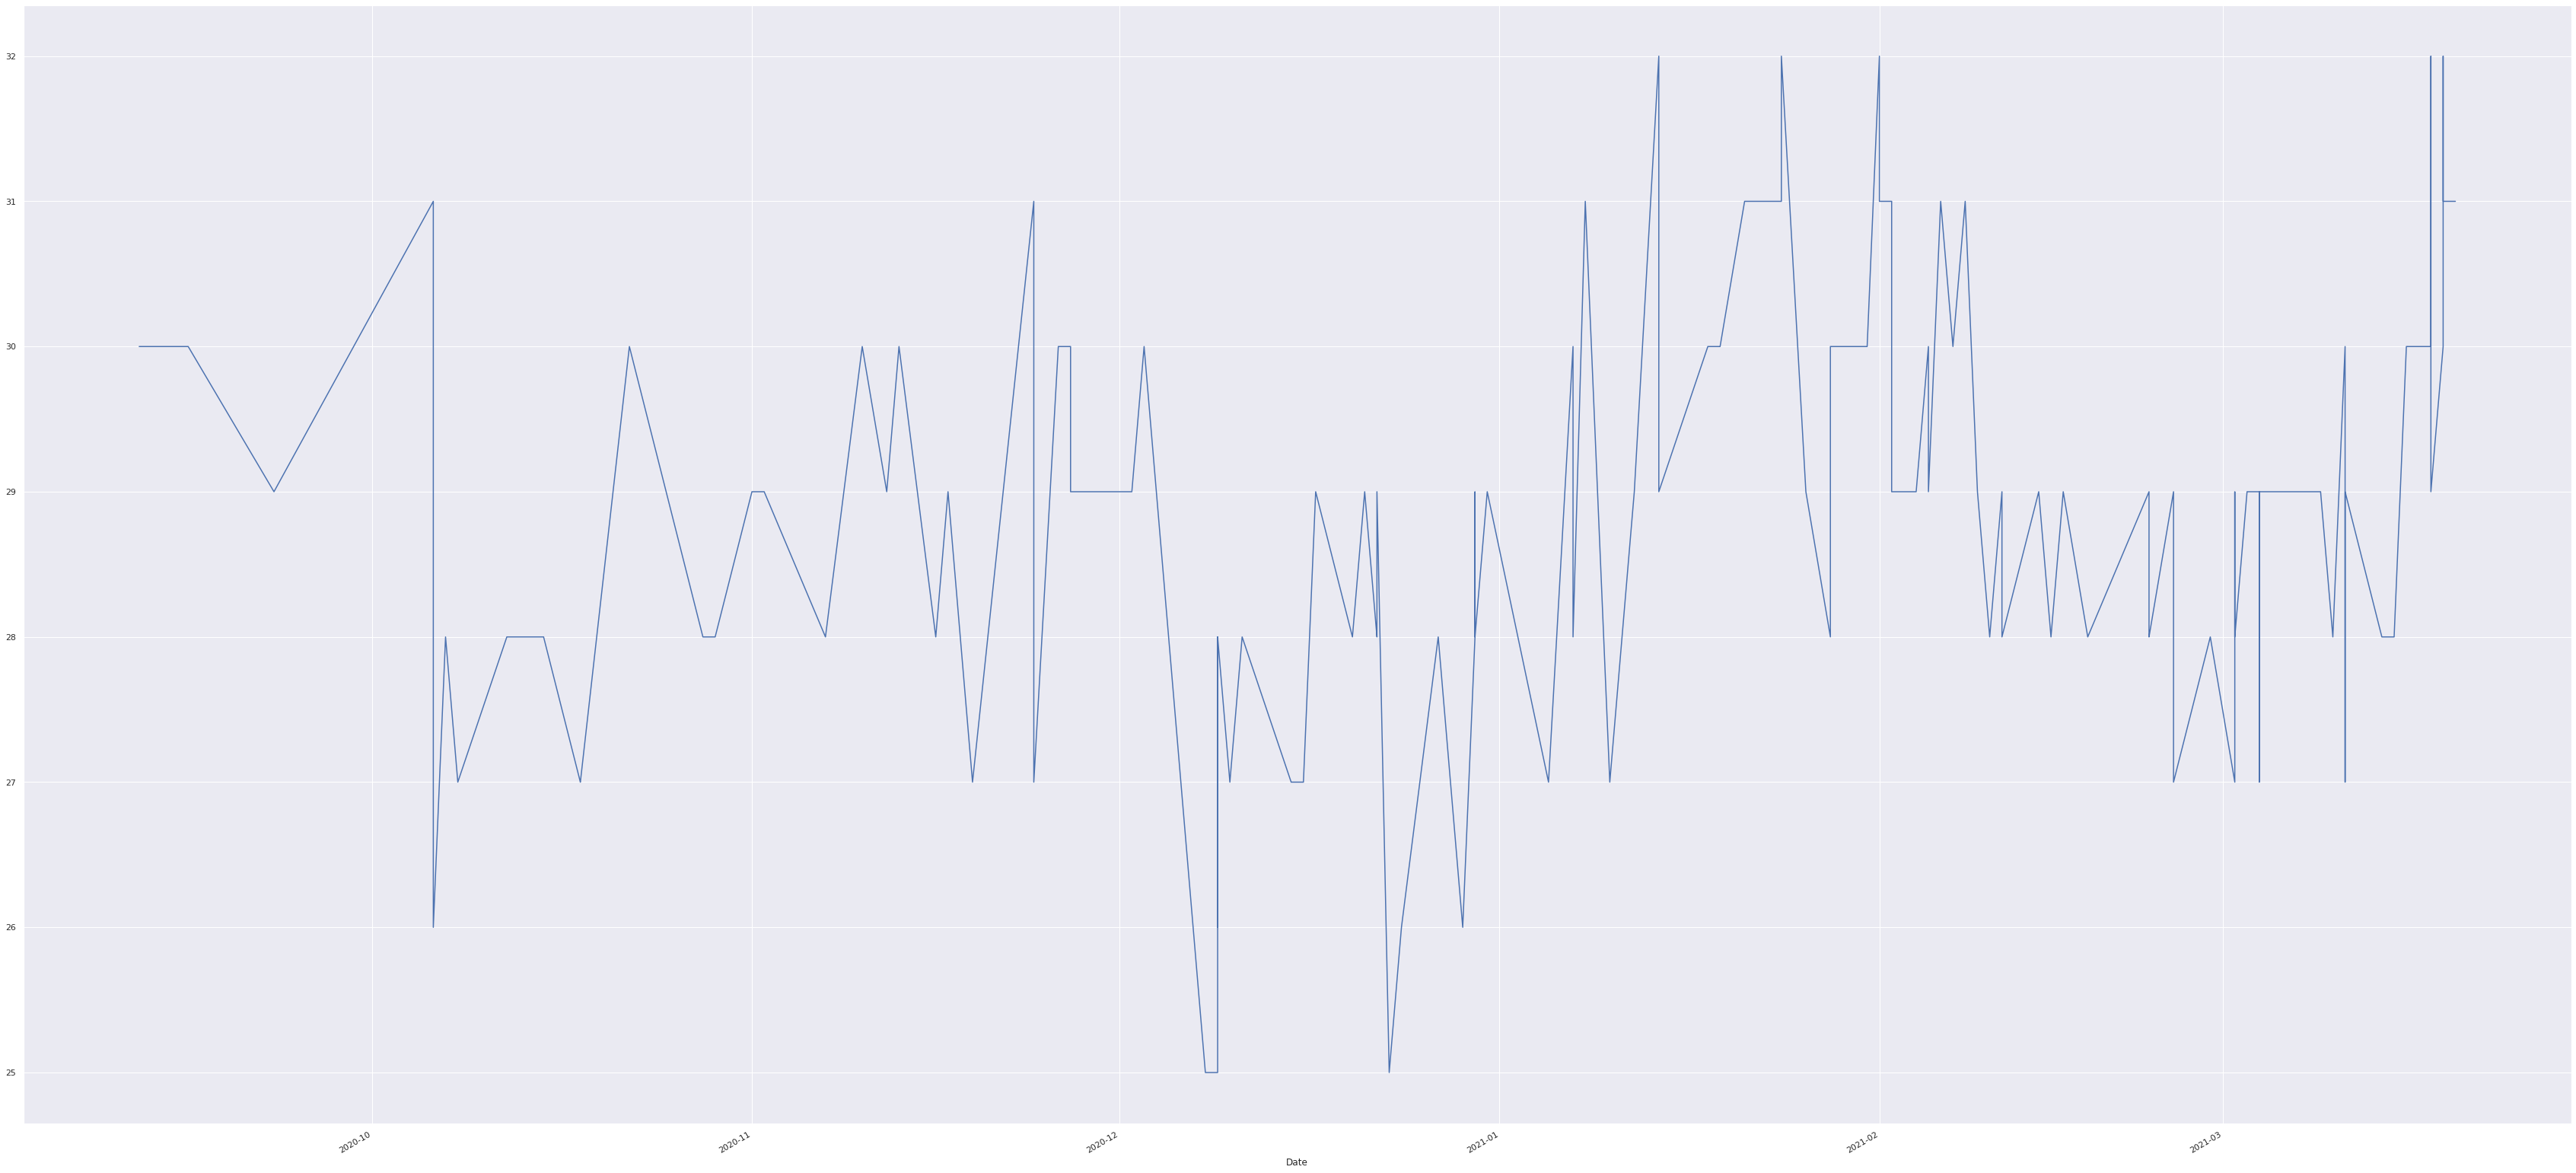

In [ ]:
Likud['Likud'].plot(figsize=(60,30))

how many samples per poll to take


In [ ]:
num_samples =10

##Create the index from the original index

In [ ]:
from datetime import datetime, timedelta

#get the datetime index from likud
Likud_index = Likud.index

#create the temporary index for the simulated election
temp_index = []

#for each poll 
for i in range(1,len(Likud)):
  #we need to stretch the index by the number of samples taken for each poll
  for x in range(0,num_samples):
    #add a second for each one(x is an index so 1 second per poll is adding x)
    temp_time = Likud_index[i]+ timedelta(seconds=x)
    #append the new streches to the index
    temp_index = np.append(temp_index, Likud_index[i])

display(temp_index)

array([Timestamp('2021-03-19 00:00:03'), Timestamp('2021-03-19 00:00:03'),
       Timestamp('2021-03-19 00:00:03'), ...,
       Timestamp('2020-09-12 00:02:02'), Timestamp('2020-09-12 00:02:02'),
       Timestamp('2020-09-12 00:02:02')], dtype=object)

Create the numpy array for the simulated election

In [ ]:
Likud_simulated = np.zeros([1, num_samples]) 

In [ ]:
display(Likud_simulated)
display(Likud_simulated.size)

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

10

Take the smaples and put them into the array

In [ ]:
#sets the first 100 spots that were zero when instantiated
Likud_simulated = np.random.normal(Likud.iloc[1,1], Likud.iloc[1, 2], num_samples)

#add 1 to start to ignore election result at the top

#for every poll in Likud
for i in range(2, len(Likud)):
  #take num_samples samples using poll size, and sigma
  s = np.random.normal(Likud.iloc[i,1], Likud.iloc[i, 2], num_samples)
  # and append them to the simulated election
  Likud_simulated =  np.append(Likud_simulated, s ,axis=0)

display(Likud_simulated.shape)
display(len(Likud))

(1200,)

121

In [ ]:
display(Likud_simulated)

array([71.82875228, 18.01302748, 52.44222077, ...,  6.34101678,
       30.00695432, 34.71526838])

In [ ]:
temp_index.shape

(1200,)

In [ ]:
#create a dataframe using the new index and the simulated data
Simulated_elections = pd.DataFrame(data = Likud_simulated, index = temp_index)
display(Simulated_elections)

,0
2021-03-19 00:00:03,71.828752
2021-03-19 00:00:03,18.013027
2021-03-19 00:00:03,52.442221
2021-03-19 00:00:03,12.682906
2021-03-19 00:00:03,36.034511
...,...
2020-09-12 00:02:02,36.231647
2020-09-12 00:02:02,50.625272
2020-09-12 00:02:02,6.341017
2020-09-12 00:02:02,30.006954


In [ ]:
display(Simulated_elections.index.values)
Simulated_elections.index.values.shape

array(['2021-03-19T00:00:03.000000000', '2021-03-19T00:00:03.000000000',
       '2021-03-19T00:00:03.000000000', ...,
       '2020-09-12T00:02:02.000000000', '2020-09-12T00:02:02.000000000',
       '2020-09-12T00:02:02.000000000'], dtype='datetime64[ns]')

(1200,)

Lowess Curve definition

In [ ]:
from statsmodels.nonparametric.smoothers_lowess import lowess

#assumes a datetime index
def make_lowess(series):
    delta = 3
    endog = series.values.reshape(-1)

    exog = series.index.values

    smooth = lowess(endog, exog, frac=(10/159))
    index, data = np.transpose(smooth)

    return pd.Series(data, index=pd.to_datetime(index)) 

In [ ]:
Simulated_election_Lowess = make_lowess(Simulated_elections.abs())

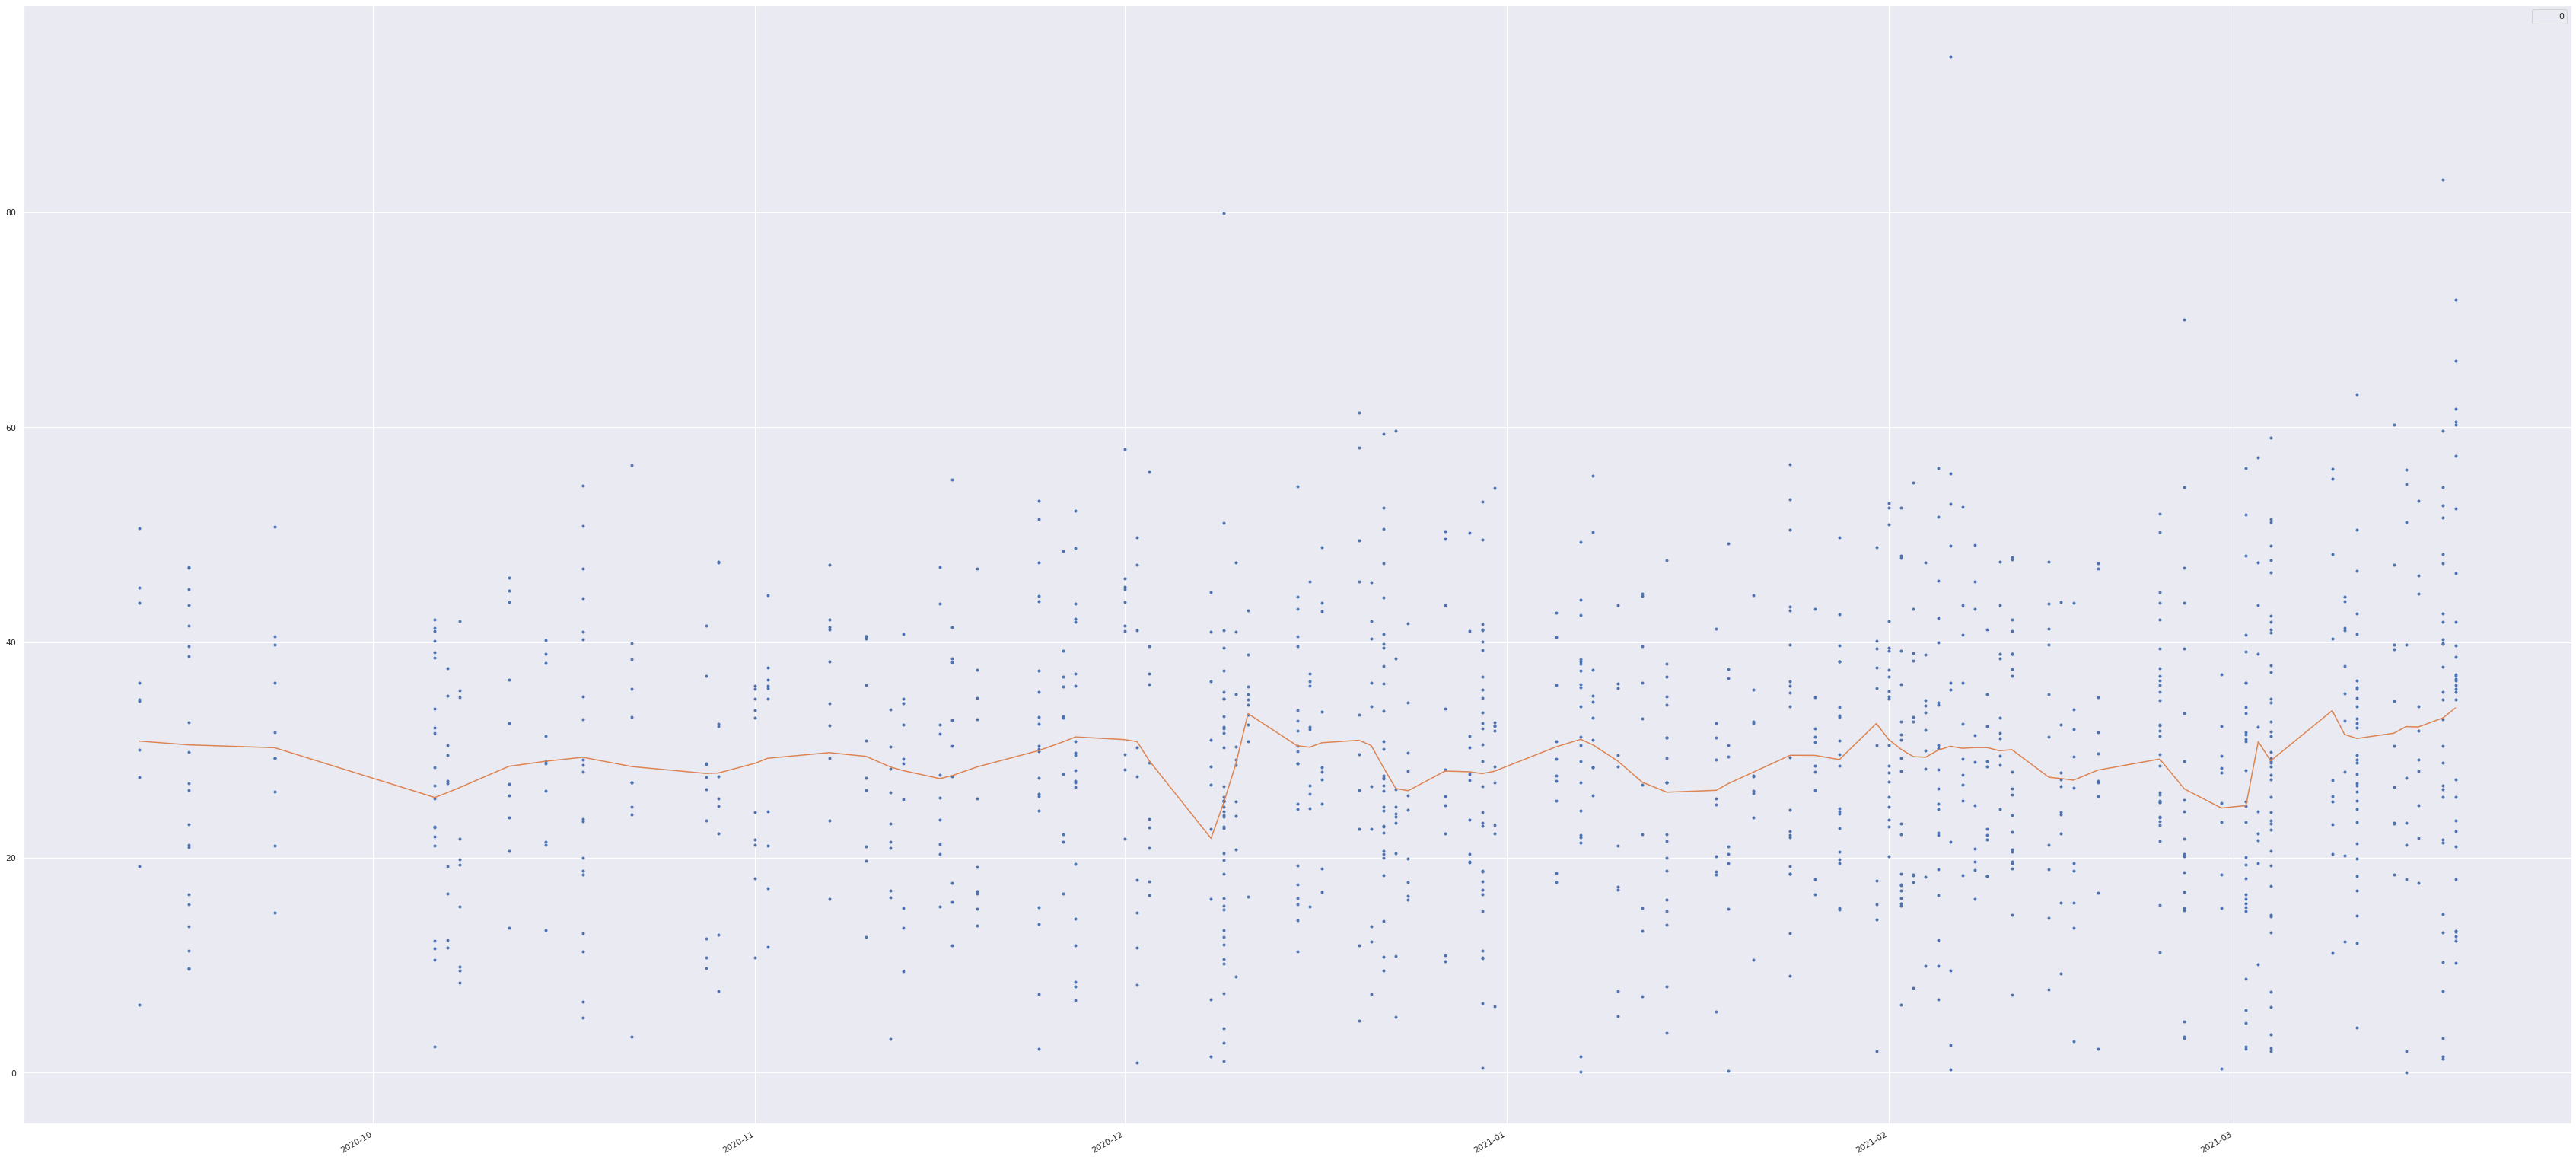

In [ ]:
Simulated_elections.abs().plot(figsize=(60,30),style= '.')
Simulated_election_Lowess.plot()